In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from datetime import timedelta
from FRVRS import fu
from FRVRS import nu
import humanize
import matplotlib.pyplot as plt
import os
import os.path as osp
import re
import pandas as pd

PNG_PATH = '../saves/png'
os.makedirs(name=PNG_PATH, exist_ok=True)


# Visualize DM/Patient Interactions

In [3]:

# Attempt to load the logs data frame
frvrs_logs_df = nu.load_data_frames(frvrs_logs_df='frvrs_logs_df')['frvrs_logs_df']
print(frvrs_logs_df.shape)

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/frvrs_logs_df.pkl.
(829116, 114)



## Visualize the Order of Responder Negotiations on one scene's timeline

In [4]:

if nu.pickle_exists('time_groups_dict'): time_groups_dict = nu.load_object('time_groups_dict')
else:
    
    # Create a boolean mask to filter action types
    start_stop_list = ['SESSION_END', 'SESSION_START']
    actions_mask_series = frvrs_logs_df.action_type.isin(fu.responder_negotiations_list + start_stop_list)
    
    # Include VOICE_COMMAND actions with specific messages in the mask
    actions_mask_series |= ((frvrs_logs_df.action_type == 'VOICE_COMMAND') & (frvrs_logs_df.voice_command_message.isin(fu.command_messages_list)))
    
    # Group each patient, run, and session with non-null patient IDs
    scene_gb = frvrs_logs_df[actions_mask_series].sort_values(['action_tick']).groupby(fu.scene_groupby_columns)
    
    # Loop through each unique file/scene/patient combination
    time_groups_dict = {}
    for (session_uuid, scene_id), scene_df in scene_gb:
        key = (session_uuid, scene_id)
        actions_list = []
        action_types_set = set()
        for row_index, row_series in scene_df.iterrows():
            action_type = row_series.voice_command_message
            if pd.notnull(action_type):
                actions_list.append(action_type)
                action_types_set.add(action_type)
            action_type = row_series.action_type
            if pd.notnull(action_type) and (action_type != 'VOICE_COMMAND'):
                actions_list.append(action_type)
                action_types_set.add(action_type)
        time_groups_dict[key] = actions_list
    
    nu.store_objects(time_groups_dict=time_groups_dict)

In [5]:

if nu.pickle_exists('summary_statistics_df'): summary_statistics_df = nu.load_object('summary_statistics_df')
else:
    from pysan import get_entropy
    from pysan import get_complexity

    rows_list = []
    for scene_tuple, sequence in time_groups_dict.items():
        row_dict = {}
        row_dict['session_uuid'] = scene_tuple[0]
        row_dict['scene_id'] = scene_tuple[1]
        row_dict['sequence_length'] = len(sequence)
        row_dict['sequence_entropy'] = get_entropy(sequence)
        row_dict['sequence_turbulence'] = nu.get_turbulence(sequence, verbose=False)
        row_dict['sequence_complexity'] = get_complexity(sequence)
        rows_list.append(row_dict)
    summary_statistics_df = pd.DataFrame(rows_list)
    nu.store_objects(summary_statistics_df=summary_statistics_df)
nu.save_data_frames(summary_statistics_df=summary_statistics_df)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/summary_statistics_df.csv


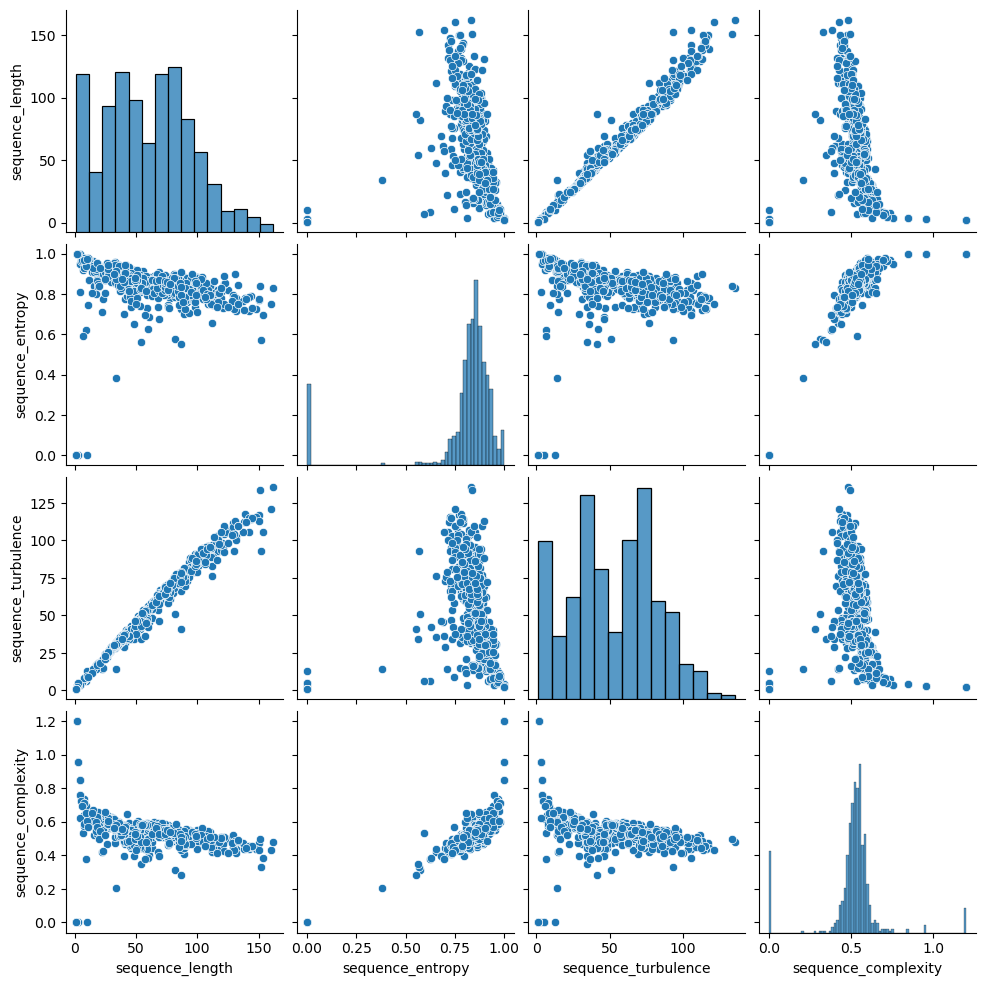

In [6]:

import seaborn as sns

columns_list = ['sequence_length', 'sequence_entropy', 'sequence_turbulence', 'sequence_complexity']
PairGrid_obj = sns.pairplot(summary_statistics_df[columns_list])

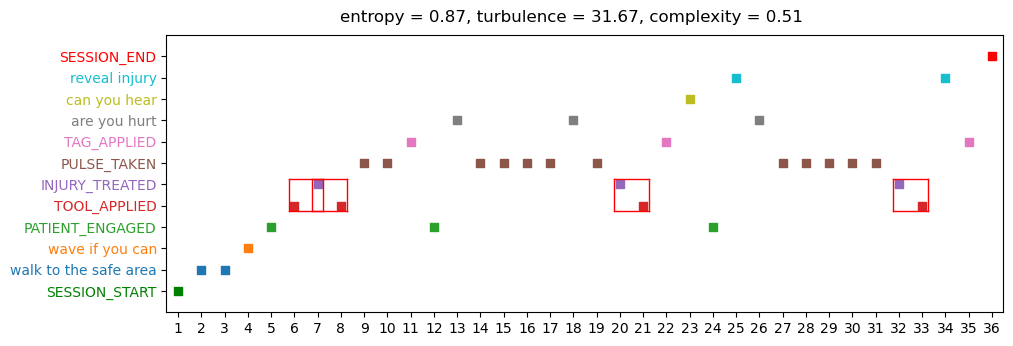

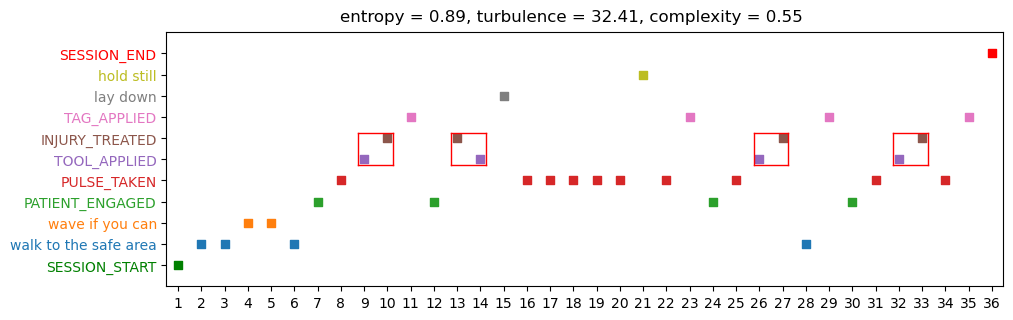

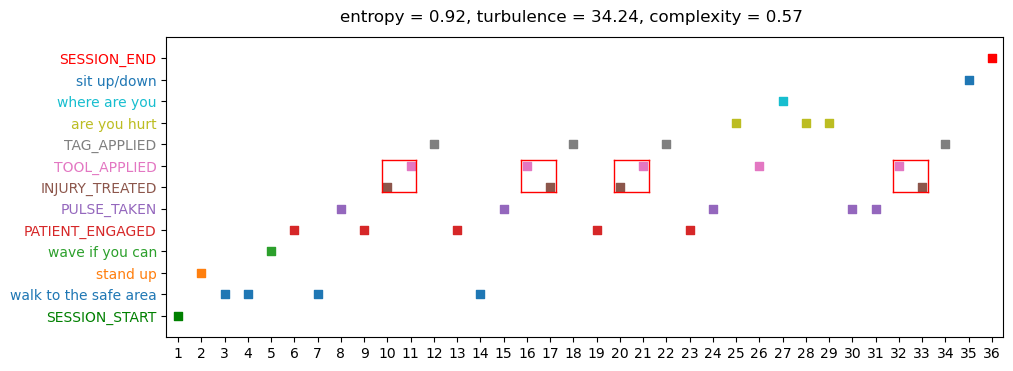

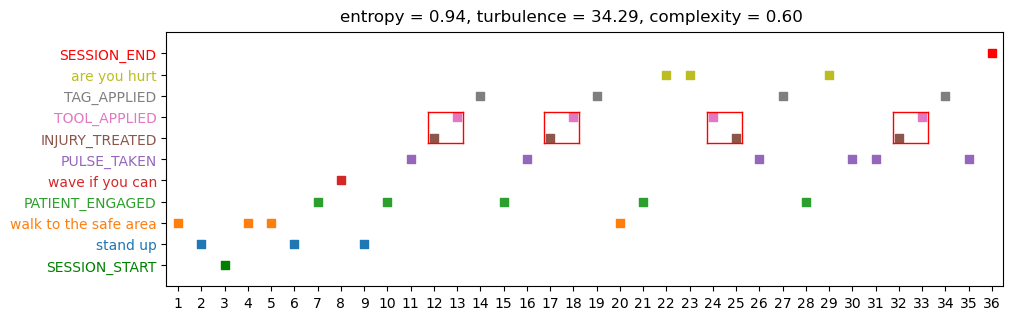

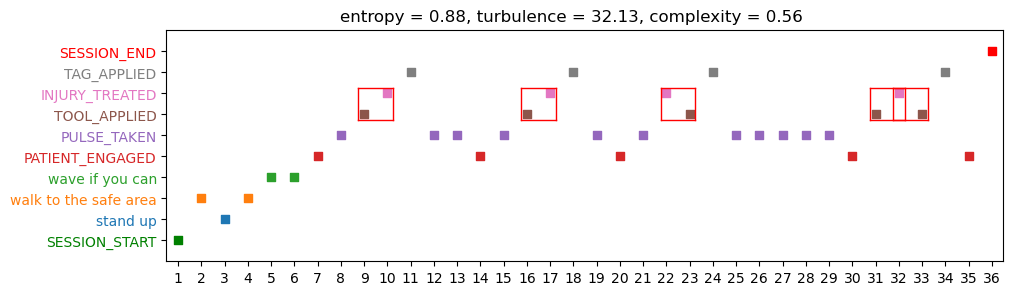

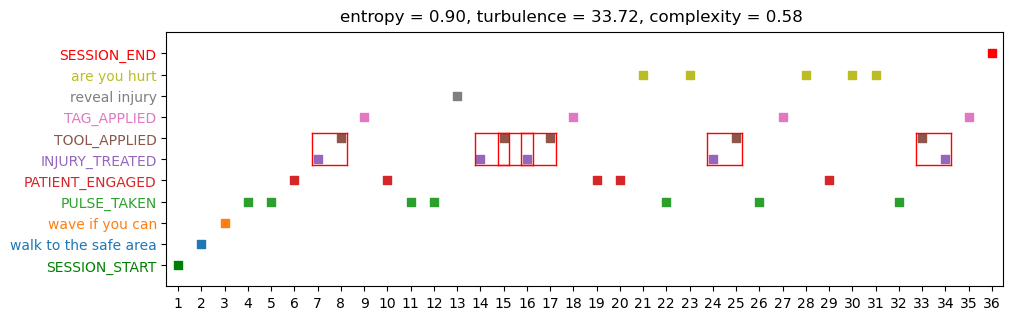

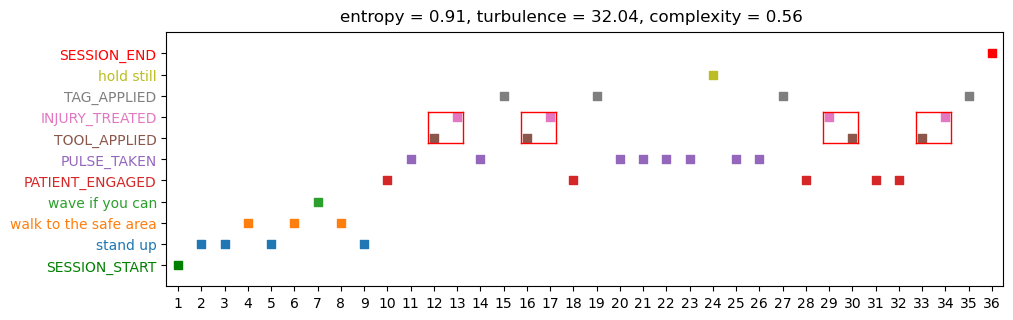

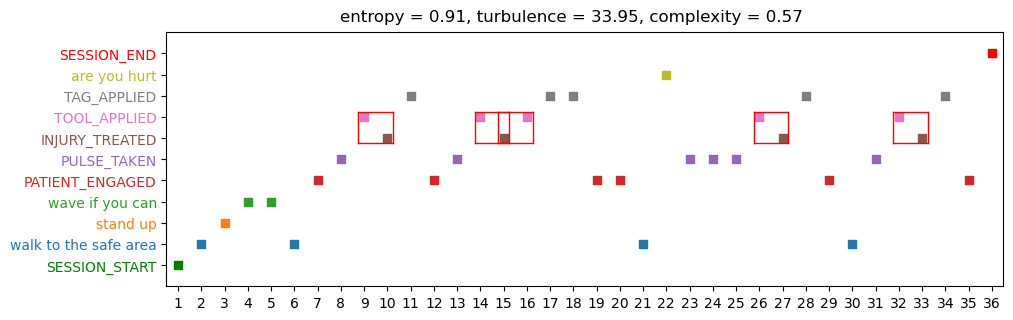

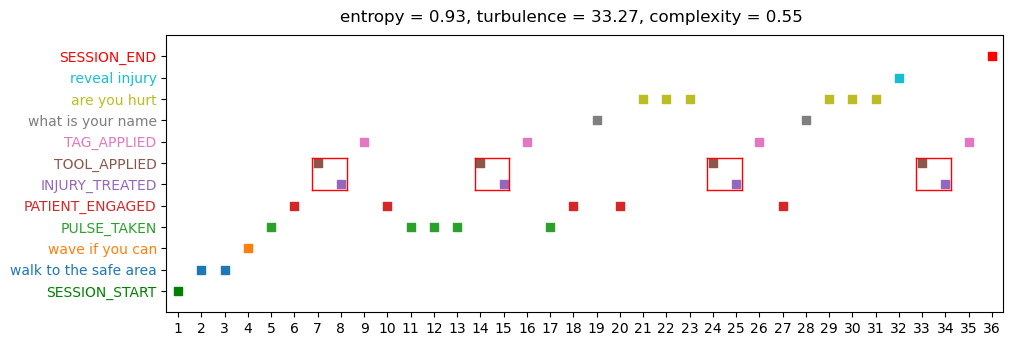

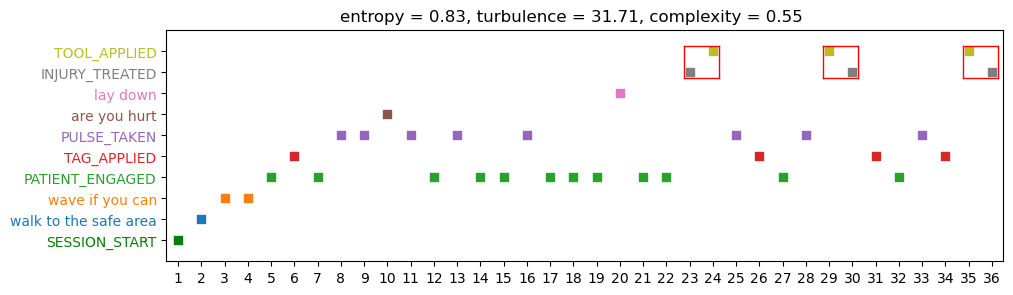

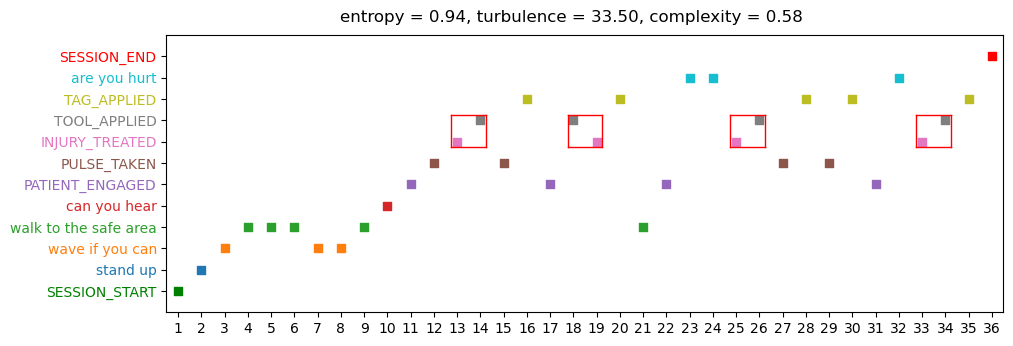

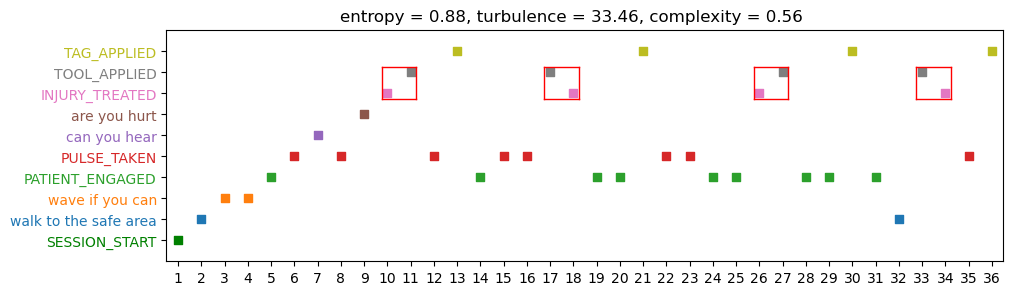

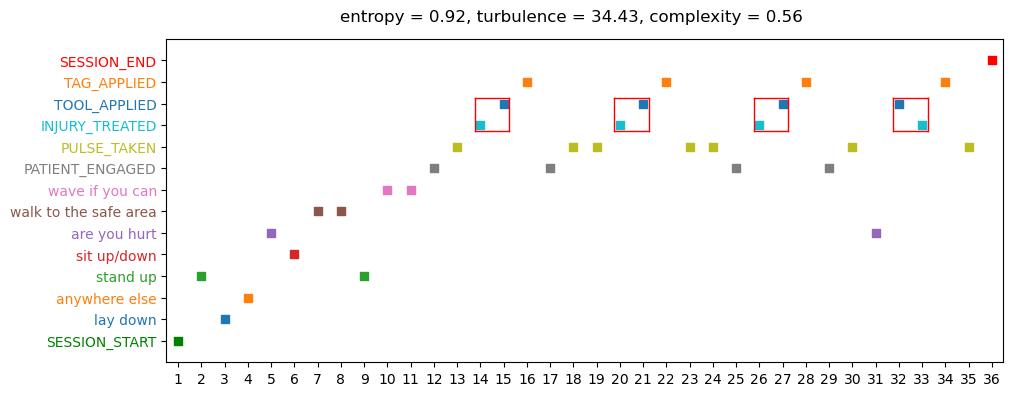

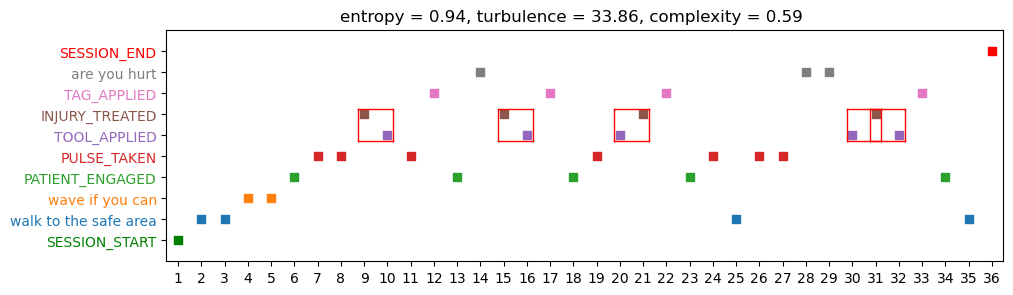

In [7]:

# Get the most popular sequence length and minmax on that
srs = summary_statistics_df.groupby('sequence_length').size().sort_values()
most_popular_length = srs[srs.index > 2].tail(1).index[0]
length_mask_series = (summary_statistics_df.sequence_length == most_popular_length)
highlighted_ngrams = [['TOOL_APPLIED', 'INJURY_TREATED'], ['INJURY_TREATED', 'TOOL_APPLIED']]

# Create a boolean mask to filter action types
start_stop_list = ['SESSION_END', 'SESSION_START']
actions_mask_series = frvrs_logs_df.action_type.isin(fu.responder_negotiations_list + start_stop_list)

# Include VOICE_COMMAND actions with specific messages in the mask
actions_mask_series |= ((frvrs_logs_df.action_type == 'VOICE_COMMAND') & (frvrs_logs_df.voice_command_message.isin(fu.command_messages_list)))

for scene_tuple, scene_df in summary_statistics_df[length_mask_series].groupby(['session_uuid', 'scene_id']):
    sequence = time_groups_dict[scene_tuple]
    fig, ax = fu.plot_sequence_by_scene_tuple(
        scene_tuple, sequence, summary_statistics_df=summary_statistics_df, actions_mask_series=actions_mask_series, frvrs_logs_df=frvrs_logs_df,
        highlighted_ngrams=highlighted_ngrams, verbose=False
    )

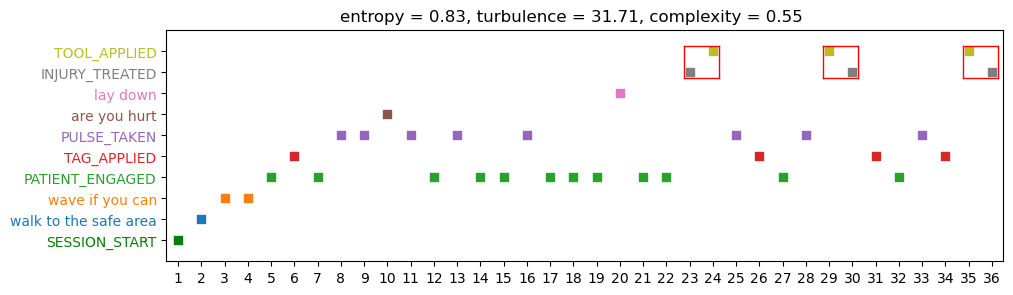

In [8]:

# Plot what minimum entropy looks like
min_entropy = summary_statistics_df[length_mask_series].sequence_entropy.min()
mask_series = (summary_statistics_df.sequence_entropy == min_entropy) & length_mask_series
for row_index, row_series in summary_statistics_df[mask_series].iterrows():
    session_uuid = row_series.session_uuid
    scene_id = row_series.scene_id
    scene_tuple = (session_uuid, scene_id) # ('c6a48228-d864-4b20-93dd-8ad0d78d59c0', 0)
    sequence = time_groups_dict[scene_tuple]
    # if len(sequence) > 1: print(scene_tuple)
    fig, ax = fu.plot_sequence_by_scene_tuple(
        scene_tuple, sequence, summary_statistics_df=summary_statistics_df, frvrs_logs_df=frvrs_logs_df, actions_mask_series=actions_mask_series,
        highlighted_ngrams=highlighted_ngrams
    )

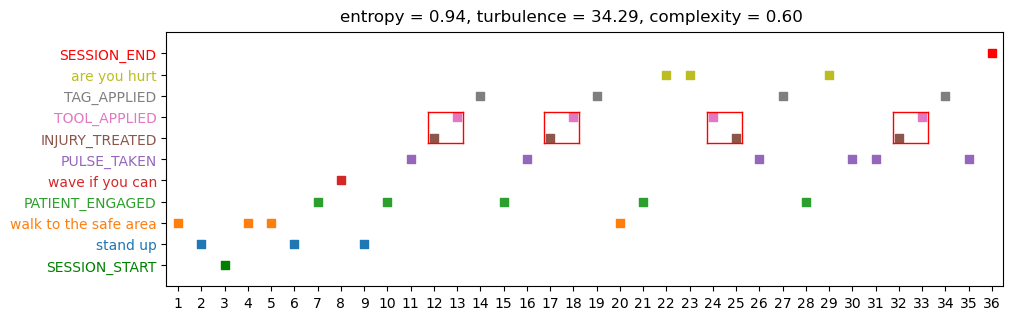

In [9]:

# Plot what maximum entropy looks like
max_entropy = summary_statistics_df[length_mask_series].sequence_entropy.max()
mask_series = (summary_statistics_df.sequence_entropy == max_entropy) & length_mask_series
for row_index, row_series in summary_statistics_df[mask_series].iterrows():
    session_uuid = row_series.session_uuid
    scene_id = row_series.scene_id
    scene_tuple = (session_uuid, scene_id) # ('c6a48228-d864-4b20-93dd-8ad0d78d59c0', 0)
    sequence = time_groups_dict[scene_tuple]
    # if len(sequence) > 1: print(scene_tuple)
    fig, ax = fu.plot_sequence_by_scene_tuple(
        scene_tuple, sequence, summary_statistics_df=summary_statistics_df, frvrs_logs_df=frvrs_logs_df, actions_mask_series=actions_mask_series,
        highlighted_ngrams=highlighted_ngrams
    )

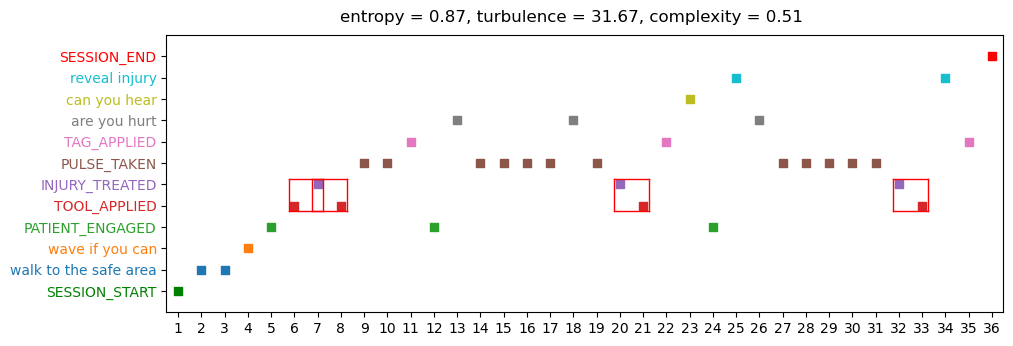

In [10]:

# Plot what minimum turbulence looks like
min_turbulence = summary_statistics_df[length_mask_series].sequence_turbulence.min()
mask_series = (summary_statistics_df.sequence_turbulence == min_turbulence) & length_mask_series
for row_index, row_series in summary_statistics_df[mask_series].iterrows():
    session_uuid = row_series.session_uuid
    scene_id = row_series.scene_id
    scene_tuple = (session_uuid, scene_id) # ('c6a48228-d864-4b20-93dd-8ad0d78d59c0', 0)
    sequence = time_groups_dict[scene_tuple]
    # if len(sequence) > 1: print(scene_tuple)
    fig, ax = fu.plot_sequence_by_scene_tuple(
        scene_tuple, sequence, summary_statistics_df=summary_statistics_df, frvrs_logs_df=frvrs_logs_df, actions_mask_series=actions_mask_series,
        highlighted_ngrams=highlighted_ngrams
    )

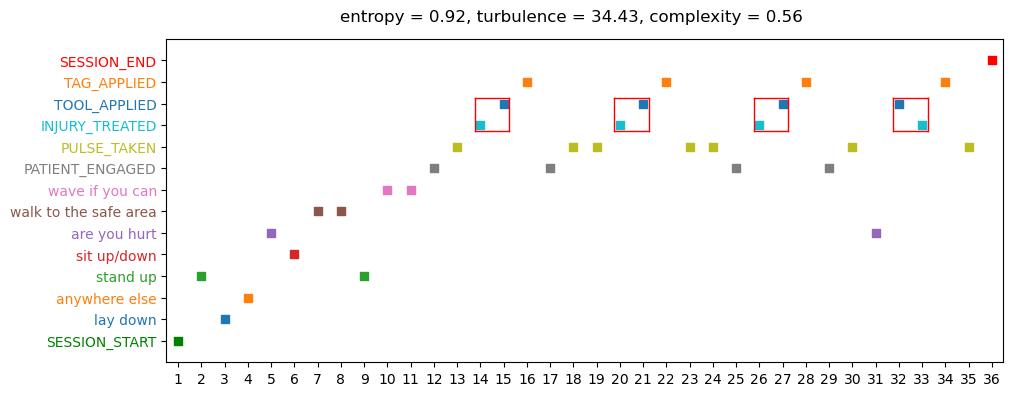

In [11]:

# Plot what maximum turbulence looks like
max_turbulence = summary_statistics_df[length_mask_series].sequence_turbulence.max()
mask_series = (summary_statistics_df.sequence_turbulence == max_turbulence) & length_mask_series
for row_index, row_series in summary_statistics_df[mask_series].iterrows():
    session_uuid = row_series.session_uuid
    scene_id = row_series.scene_id
    scene_tuple = (session_uuid, scene_id) # ('c6a48228-d864-4b20-93dd-8ad0d78d59c0', 0)
    sequence = time_groups_dict[scene_tuple]
    # if len(sequence) > 1: print(scene_tuple)
    fig, ax = fu.plot_sequence_by_scene_tuple(
        scene_tuple, sequence, summary_statistics_df=summary_statistics_df, frvrs_logs_df=frvrs_logs_df, actions_mask_series=actions_mask_series,
        highlighted_ngrams=highlighted_ngrams
    )

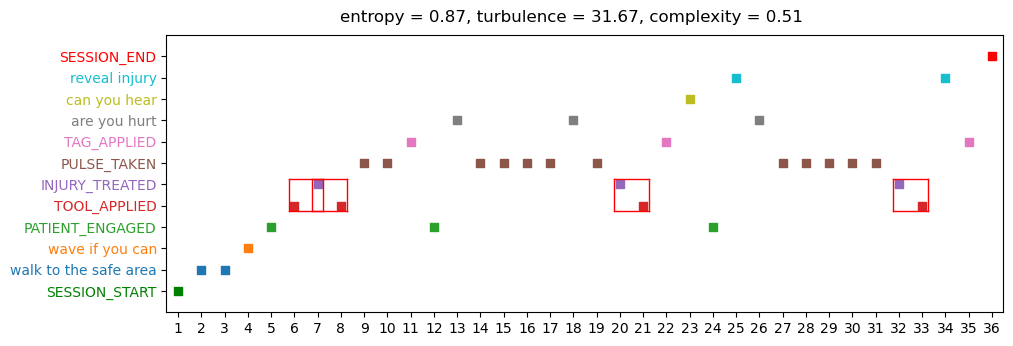

In [12]:

# Plot what minimum complexity looks like
min_complexity = summary_statistics_df[length_mask_series].sequence_complexity.min()
mask_series = (summary_statistics_df.sequence_complexity == min_complexity) & length_mask_series
for row_index, row_series in summary_statistics_df[mask_series].iterrows():
    session_uuid = row_series.session_uuid
    scene_id = row_series.scene_id
    scene_tuple = (session_uuid, scene_id) # ('c6a48228-d864-4b20-93dd-8ad0d78d59c0', 0)
    sequence = time_groups_dict[scene_tuple]
    # if len(sequence) > 1: print(scene_tuple)
    fig, ax = fu.plot_sequence_by_scene_tuple(
        scene_tuple, sequence, summary_statistics_df=summary_statistics_df, frvrs_logs_df=frvrs_logs_df, actions_mask_series=actions_mask_series,
        highlighted_ngrams=highlighted_ngrams
    )

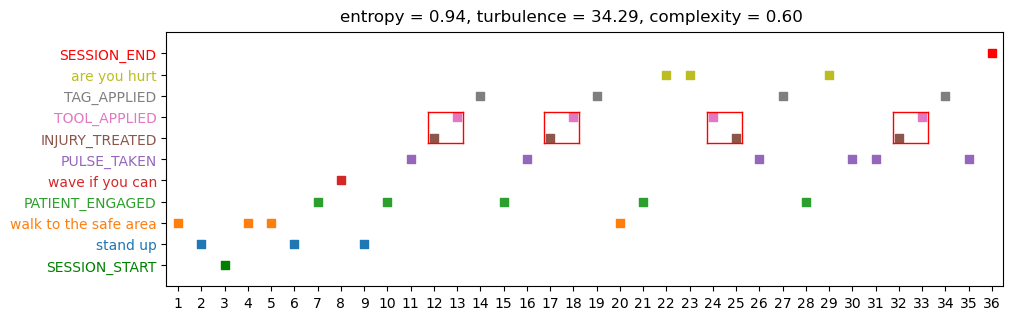

In [13]:

# Plot what maximum complexity looks like
max_complexity = summary_statistics_df[length_mask_series].sequence_complexity.max()
mask_series = (summary_statistics_df.sequence_complexity == max_complexity) & length_mask_series
for row_index, row_series in summary_statistics_df[mask_series].iterrows():
    session_uuid = row_series.session_uuid
    scene_id = row_series.scene_id
    scene_tuple = (session_uuid, scene_id) # ('c6a48228-d864-4b20-93dd-8ad0d78d59c0', 0)
    sequence = time_groups_dict[scene_tuple]
    # if len(sequence) > 1: print(scene_tuple)
    fig, ax = fu.plot_sequence_by_scene_tuple(
        scene_tuple, sequence, summary_statistics_df=summary_statistics_df, frvrs_logs_df=frvrs_logs_df, actions_mask_series=actions_mask_series,
        highlighted_ngrams=highlighted_ngrams
    )